In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import geometry
import shapely.speedups
from tqdm import tqdm
from syspy.skims import skims
from sklearn.cluster import KMeans
from quetzal.model import stepmodel
from quetzal.io import excel

# Preparation of input data
## Generates a DataFrame of PT stops with mean weighted distances to population cells
## Needs original PT nodes

In [5]:
input_path = '../input_static/spatial_'
output_path = '../output/'
model_path = '../input_static/'
zone_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [13]:
sm = stepmodel.read_json(model_path + 'de_pt_network')
z = stepmodel.read_json(zone_path + 'de_zones')
sm.zones = z.zones

In [14]:
# Map nodes to zones
if 'FID' not in sm.nodes.columns:
    shapely.speedups.enable()
    sm.nodes['FID'] = np.nan
    sm.nodes = gpd.GeoDataFrame(sm.nodes, crs=sm.epsg)
    for _, zone in tqdm(sm.zones.iterrows(), total=sm.zones.shape[0]):
        sm.nodes.loc[sm.nodes['geometry'].within(zone['geometry']), 'FID'] = zone['FID']
    #sm.nodes.to_file(model_path + 'de_pt_network/nodes.geojson', driver='GeoJSON', encoding='utf-8')

100%|█████████████████████████████████████████████████████████████████████████████| 4602/4602 [00:08<00:00, 540.38it/s]


In [8]:
bus = stepmodel.read_json(model_path + 'de_pt_network_bus')

In [12]:
# Map bus nodes to zones
if 'FID' not in bus.nodes.columns:
    shapely.speedups.enable()
    bus.nodes['FID'] = np.nan
    bus.nodes = gpd.GeoDataFrame(bus.nodes, crs=sm.epsg)
    for _, zone in tqdm(sm.zones.iterrows(), total=sm.zones.shape[0]):
        bus.nodes.loc[bus.nodes['geometry'].within(zone['geometry']), 'FID'] = zone['FID']
    #bus.nodes.to_file(model_path + 'de_pt_network_bus/nodes.geojson', driver='GeoJSON', encoding='utf-8')

100%|██████████████████████████████████████████████████████████████████████████████| 4602/4602 [03:28<00:00, 22.10it/s]


In [15]:
# Merge
sm.nodes = pd.concat([sm.nodes, bus.nodes])

In [ ]:
# Add reactivated rail nodes, if set in scenario
if not params['network_reactivation']['inclusion_reason'] is None:
    # TODO
    pass

## Load census data

In [16]:
# Load census data: Zensus 2011 - Einwohnerzahl je Hektar
# Copyright: © Statistisches Bundesamt, Wiesbaden 2015
# (im Auftrag der Herausgebergemeinschaft)
# Vervielfältigung und Verbreitung, auch auszugsweise, mit Quellenangabe gestattet
if os.path.isfile(input_path + 'Zensus_2011.geojson'):
    pop = gpd.read_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')
else:
    pop = pd.read_csv(input_path + 'Zensus_2011.csv', sep=';')
    # Restrict to entries that hold information
    pop = pop.loc[pop['Einwohner']!=-1]
    pop = gpd.GeoDataFrame(pop[['Einwohner']],
                          geometry=gpd.points_from_xy(pop['x_mp_100m'], pop['y_mp_100m']))
    pop.crs = 3035
    pop.to_crs(sm.epsg, inplace=True)

In [17]:
print(pop.shape)
pop.head(2)

(3177723, 4)


,Einwohner,NUTS_ID,FID,geometry
0,8,DE27E,DE27E_8,POINT (10.21212 47.31574)
1,7,DE27E,DE27E_8,POINT (10.26631 47.31562)


In [18]:
pop_r = pop

In [13]:
# Restrict to a geometric hull
#sm.zones = gpd.GeoDataFrame(sm.zones)
#hull = sm.zones["geometry"].buffer(1e-3).unary_union
# Restrict to the geometric hull if the latter is not Germany
#pop_r = pop.loc[pop['geometry'].apply(lambda p: p.within(hull))]
#print(pop_r.shape)

In [19]:
# Map to zones
if not 'FID' in pop_r.columns or set(pop_r['FID']) != set(sm.zones['FID']):
    shapely.speedups.enable()
    zones = gpd.GeoDataFrame(sm.zones.sort_values('area', ascending=False), crs=sm.epsg)
    #centr['geometry'] = zones['geometry'].centroid
    pop_r['FID'] = np.nan
    for _, zone in tqdm(zones.iterrows(), total=sm.zones.shape[0]):
        geo = zone['geometry'].buffer(0.08)
        pop_r.loc[pop_r['geometry'].within(geo), 'FID'] = zone['FID']
    pop_r.to_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')

100%|██████████████████████████████████████████████████████████████████████████████| 4602/4602 [25:24<00:00,  3.02it/s]


In [20]:
pop_r.loc[pop_r['FID'].isna()]

,Einwohner,NUTS_ID,FID,geometry


In [21]:
sm.nodes.shape

(410735, 4)

## Apply K-Means to find weighted distances of PT stops
The important question for mode choice problems: How long/inconvenient is it from home to the next PT stop? </br>
Approach: Build population densities from census data and calculate the mean weighted distance to the next PT stop.

In [22]:
# Settings:
dist_col = 'weighted_dist'
mean_dist_col = 'mean_weighted_dist'
cent_col = 'cluster_center'
pop_col = 'population'
max_iter_per_group = 10
tqdm.pandas()
errors = []

In [23]:
def weighted_dist(zone):
    nuts_id = zone['FID'].unique()[0]
    # Get the population points
    pop_p = pop_r.loc[pop_r['FID']==nuts_id]
    # Count the number of PT stops in the zone and make it the number of clusters
    n_clusters = len(zone.index)
    if n_clusters > 0:
        # Prepare sample
        X = np.array([[p.x, p.y] for p in list(pop_p['geometry'])])
        # Prepare initial starting points
        nodes_coords = np.array([[p.x, p.y] for p in list(zone['geometry'])])
        # Apply weighted K-Means
        kmeans = KMeans(n_clusters=n_clusters,
                        random_state=0,
                        init=nodes_coords,
                        max_iter=max_iter_per_group)
        try:
            kmeans.fit(X, sample_weight=np.array(list(pop_p['Einwohner'])))
        except ValueError: # More stations than samples
            zone[cent_col] = zone['geometry']
            zone[pop_col] = pop_p['Einwohner'].sum() / n_clusters
            zone[dist_col] = 100
            zone[mean_dist_col] = 100
            return zone
        # Create results DataFrame
        zone[cent_col] = [geometry.Point(c[0], c[1]) for c in kmeans.cluster_centers_]
        # Add population to calculate the mean weighted distance for each zone later
        pop_p['cluster'] = list(kmeans.labels_)
        #    kmeans.predict(X, sample_weight=np.array(list(pop_p['Einwohner']))))
        try:
            zone[pop_col] = list(pop_p.groupby('cluster').agg({'Einwohner': 'sum'})['Einwohner'])
        except ValueError: # Fewer labels than n_clusters
            zone[pop_col] = pop_p['Einwohner'].mean()
            errors.append((nuts_id, zone['route_type'].unique()[0]))
        # Calculate distance between centroid and PT node
        zone[dist_col] = [skims.get_distance_from_lon_lat_in_m(kmeans.cluster_centers_[i][0],
                                                               kmeans.cluster_centers_[i][1],
                                                               nodes_coords[i][0],
                                                               nodes_coords[i][1])
                          for i in range(n_clusters)]
        # Add mean weighted distance
        zone[mean_dist_col] = (zone[pop_col]*zone[dist_col]).sum() / zone[pop_col].sum()
        return zone
    else:
        return

In [20]:
# Generate mean weighted distances for every route type
#node_dist = sm.nodes.groupby(['route_type', 'FID']).progress_apply(weighted_dist)

In [21]:
len(errors)

0

## Alternative: Catchment area distances by access mode
Compute mean weighted distances considering distinct catchment radii by access mode (walking, cycling, car). Each PT stop has a population catchment (by access mode) and a service frequency, which both weight the distance to census centroids within the stop's catchment.

Given modal split for PT access/egress trips by urbanisation degree, they result in a weighted mean distance.

In [24]:
# Count services by stop_id
service_count_dict = sm.links.groupby('a').count()['b'].to_dict()
service_count_dict.update(bus.links.groupby('a').count()['b'].to_dict())
len(service_count_dict) # number of stops reported here

405889

In [25]:
try:
    urban_dict = sm.zones.set_index('FID')['urbanisation'].to_dict()
except KeyError:
    urban_dict = sm.zones['urbanisation'].to_dict()

In [26]:
def weighted_dist_2(zone):
    if len(zone.index) < 1:
        return
    nuts_id = zone['FID'].unique()[0]
    # Get population points
    pop_z = pop_r.loc[pop_r['FID']==nuts_id]
    if len(pop_z) < 1:
        return

    # Calculate distances to every stop
    pop_z['lon'] = pop_z['geometry'].apply(lambda g: g.coords[0][0])
    pop_z['lat'] = pop_z['geometry'].apply(lambda g: g.coords[0][1])
    for stop, row in zone.iterrows():
        pop_z[stop] = skims.get_distance_from_lon_lat_in_m(
            pop_z['lon'], pop_z['lat'], row['geometry'].coords[0][0], row['geometry'].coords[0][1])

    # Calculate population catchment distance by access mode
    # Weight it by population and distance (linear)
    def pop_weighted_dist(distances, populations, threshold):
        pop_weighted = populations * (distances/threshold)
        return (distances * pop_weighted).sum() / pop_weighted.sum()
    for mode in ['walk', 'bicycle', 'car']:
        thresh = params['pt_access']['catchment_radius_'+mode]
        zone[(dist_col, mode)] = [pop_weighted_dist(
            pop_z.loc[pop_z[stop]<=thresh, stop], pop_z.loc[pop_z[stop]<=thresh, 'Einwohner'], thresh)
                                  for stop in zone.index]

    # Get service frequency
    zone['n_services'] = zone.index.map(service_count_dict).fillna(1)

    # Put it all together: mean weighted distance per zone
    zone[mean_dist_col] = sum([(zone[mode_dist_col] * zone['n_services']).sum() / zone['n_services'].sum()
                               * float(params['pt_access'][
                                   'urban'+str(int(urban_dict[nuts_id]))+'_'+str(mode_dist_col[1])+'_share'])
                               for mode_dist_col in zone.columns if mode_dist_col[0]==dist_col])
    return zone

In [27]:
node_dist = sm.nodes.groupby(['route_type', 'FID']).apply(weighted_dist_2)

In [28]:
node_dist.sample(4)

stop_name route_type  \
route_type FID        index                                                  
bus        51200000.0 bus_n_75595             Remscheid Rauhaus        bus   
           34590005.0 bus_n_41106        Hardensetten, Voßbrink        bus   
           59660004.0 bus_x_n_467689             Attendorn Ewig        bus   
           57580012.0 bus_n_395658    Herford, Paracelsusstraße        bus   

                                                      geometry         FID  \
route_type FID        index                                                  
bus        51200000.0 bus_n_75595     POINT (7.16047 51.18632)  51200000.0   
           34590005.0 bus_n_41106     POINT (8.08508 52.07824)  34590005.0   
           59660004.0 bus_x_n_467689  POINT (7.88199 51.11687)  59660004.0   
           57580012.0 bus_n_395658    POINT (8.70585 52.12432)  57580012.0   

                                      (weighted_dist, walk)  \
route_type FID        index                                   
bus        51200000.0 bus_n_75595                       NaN   
           34590005.0 bus_n_41106                       NaN   
           59660004.0 bus_x_n_467689                    NaN   
           57580012.0 bus_n_395658                      NaN   

                                      (weighted_dist, bicycle)  \
route_type FID        index                                      
bus        51200000.0 bus_n_75595                  3023.775847   
           34590005.0 bus_n_41106                  7412.851945   
           59660004.0 bus_x_n_467689                       NaN   
           57580012.0 bus_n_395658                         NaN   

                                      (weighted_dist, car)  n_services  \
route_type FID        index                                              
bus        51200000.0 bus_n_75595              3023.775847         4.0   
           34590005.0 bus_n_41106              7412.851945         1.0   
           59660004.0 bus_x_n_467689          12817.772687         1.0   
           57580012.0 bus_n_395658            16234.904647         1.0   

                                      mean_weighted_dist  
route_type FID        index                               
bus        51200000.0 bus_n_75595             302.864909  
           34590005.0 bus_n_41106             959.112086  
           59660004.0 bus_x_n_467689          969.017732  
           57580012.0 bus_n_395658            970.342324

In [29]:
node_dist.reset_index(level=['route_type', 'FID'], drop=True, inplace=True)

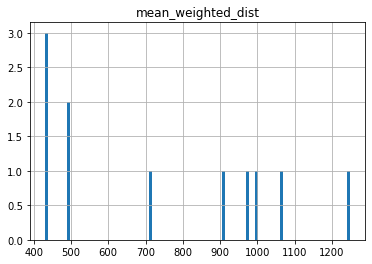

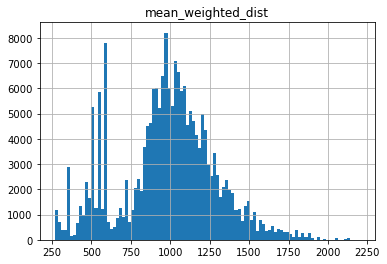

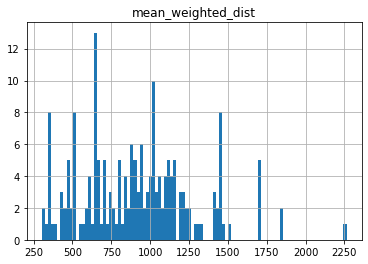

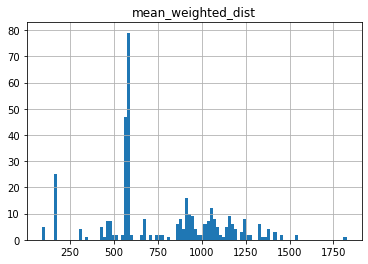

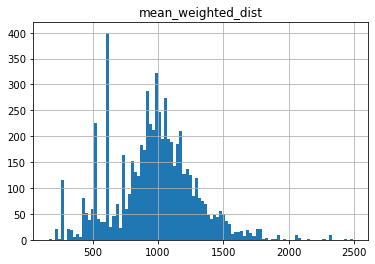

In [30]:
if manual: node_dist.groupby('route_type').hist(column=mean_dist_col, bins=100)

In [31]:
# Save the population centroids
node_dist.to_csv('../input/spatial_census_refined.csv')